This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting heart failure onset risk using pytorch library
* For this demonstration, the data is an big dataset that combines 3 hospitals (143,104,118) previously used by retain, with 145,095 patients in total 
* The logistic regression model has the architecture of an embedding layer (embedding dimension =2), a linear activation and sigmoid transformation
* Our model achieves overall 0.7633 test auc (visits < 5: 0.7608 test auc, visit >= 5: 0.7734 test auc), with corresponding 0.7630 validation auc on epoch 13
* Since the embedding dimension =2, we plot the embedded matrix colored by predicted labels vs embedded matrix colored by real labels to demonstrate how the classifications evolves with epoches
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end
* Since github does not render Plotly graph, we upload a static one, and if you're curious about the original interactive plot, you can also click on the link provided

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce 

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_em as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_em as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda
torch.cuda.set_device(0)

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-7.8810)
args.L2 = np.exp(-5.8401)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
def data_load_split_VT(folder = 'data2/cerner/hospital_data/', hosp_list=[143,104,118], test_r=0.2 , valid_r=0.1):

   merged_set=[]
   for h in hosp_list:
       seqFile= folder+'h'+str(h)+'.visits'
       labelFile= folder+'h'+str(h)+'.labels'
       set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
       set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
       merged_set_h = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists
       #merged_set_h_f = [[set_y[i],set_x[i][:-1]] for i in range(len(set_x))] # added [:-1] to exclude last visit
       #merged_set_h =[x for x in merged_set_f if len(x[1])>0]

       merged_set.extend(merged_set_h)

   #print (set_y[1],set_x[1][:-1], len(set_x[1][:-1]))

   # set random seed
   random.seed( 3 )

   dataSize = len(merged_set)
   nTest = int(test_r * dataSize)
   nValid = int(valid_r * dataSize)

   random.shuffle(merged_set)

   test_set = merged_set[:nTest]
   valid_set = merged_set[nTest:nTest+nValid]
   train_set = merged_set[nTest+nValid:]

   return train_set, valid_set, test_set

In [6]:
train1 , valid1, test1 = data_load_split_VT()
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))

101567 14509 29019


In [7]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[195, 182, 305], [156, 3067, 22, 203, 23, 1259, 262, 883, 761, 956, 857, 102, 1782, 283, 2453], [212, 140], [12, 156, 88, 212, 157, 161, 22, 23, 1259, 135, 167, 429, 855, 224, 31, 857, 282, 1782, 10, 2453, 1035]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [1250, 345, 84, 85, 1747, 5619, 345, 84, 85, 5619, 2898, 1, 307, 6, 79, 8, 44, 345, 84, 85, 622, 1677, 1453, 250, 345, 84, 85, 5318, 144, 84, 85, 1250, 144, 84, 85, 632, 375, 144, 84, 85, 632, 617, 1453, 144, 84, 85, 632, 1250, 144, 84, 85]]
[0, [671, 537, 149, 62, 85]]
[0, [1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85]]


Parameter containing:
 7.0779e-01  1.1133e+00
 2.9179e-01  4.2987e-03
 2.2175e+00  1.2483e+00
           ⋮            
 3.5120e-01 -1.4486e+00
 4.4085e-01 -1.8093e+00
 4.5374e-01  1.4666e-01
[torch.FloatTensor of size 20000x2]

15815
      emb_0     emb_1                           types
0  0.707790  1.113296                            Code
1  0.291788  0.004299  b'M_ACETAMINOPHEN-HYDROCODONE'
2  2.217472  1.248260         b'M_BACITRACIN TOPICAL'
3 -1.334870  0.004965    b'M_BUPIVACAINE-EPINEPHRINE'
4 -0.166511  0.785666                  b'M_CEFAZOLIN'


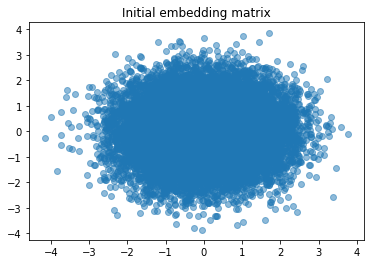

In [8]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [9]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep = []
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.4028431897649453


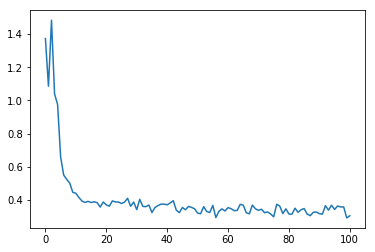

Epoch  0 Summary:  Training_auc : 0.7447004959782412  , Validation_auc :  0.7361248858134491  ,Test_auc :  0.7439713909171595 Test_auc on short visits: 0.7451723917695503 Test_auc on long visits: 0.7529727950617122  Avg Loss:  0.4028431897649453 Train Time (2m 40s) Eval Time (2m 29s)


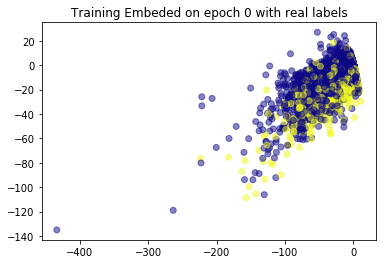

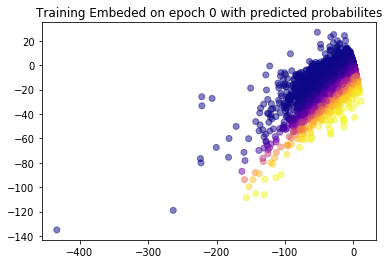


 Current running on: Epoch  1 Training loss:  Average loss 0.3327917620756299


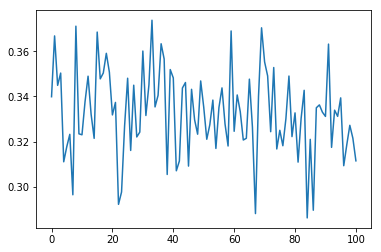

Epoch  1 Summary:  Training_auc : 0.7467398342217926  , Validation_auc :  0.7374759683181077  ,Test_auc :  0.7428578967683768 Test_auc on short visits: 0.7474753897187445 Test_auc on long visits: 0.754689628443424  Avg Loss:  0.3327917620756299 Train Time (3m 22s) Eval Time (2m 13s)


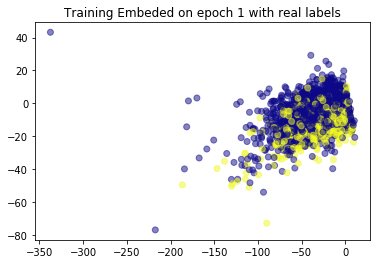

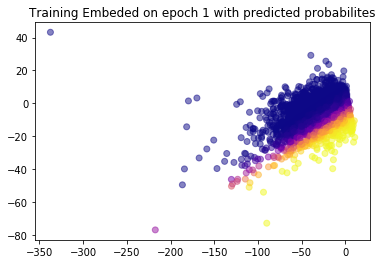


 Current running on: Epoch  2 Training loss:  Average loss 0.3310022397274131


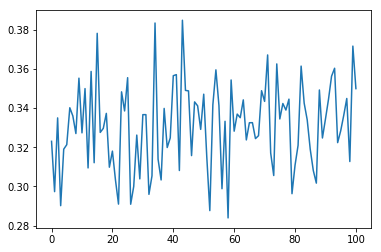

Epoch  2 Summary:  Training_auc : 0.7715071322721154  , Validation_auc :  0.7612343871961507  ,Test_auc :  0.7644799007861849 Test_auc on short visits: 0.7590179450857728 Test_auc on long visits: 0.776199157890617  Avg Loss:  0.3310022397274131 Train Time (3m 2s) Eval Time (2m 23s)


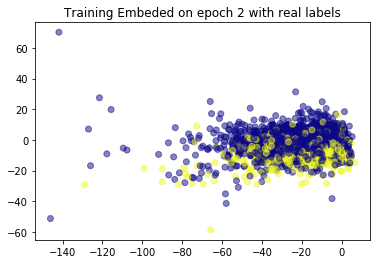

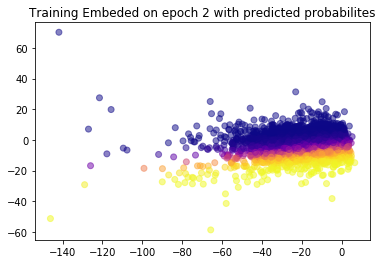


 Current running on: Epoch  3 Training loss:  Average loss 0.329939857137316


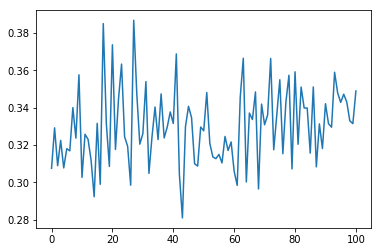

Epoch  3 Summary:  Training_auc : 0.7692259095698977  , Validation_auc :  0.7578194534647396  ,Test_auc :  0.7640275354964685 Test_auc on short visits: 0.7598052154078736 Test_auc on long visits: 0.7735339458358202  Avg Loss:  0.329939857137316 Train Time (3m 24s) Eval Time (2m 34s)


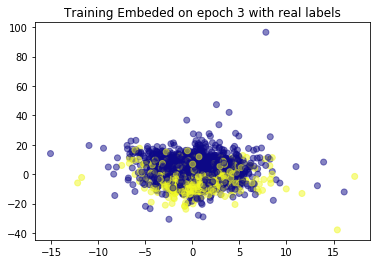

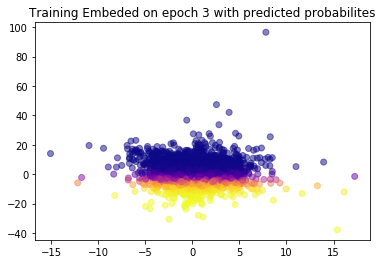


 Current running on: Epoch  4 Training loss:  Average loss 0.3297672051649792


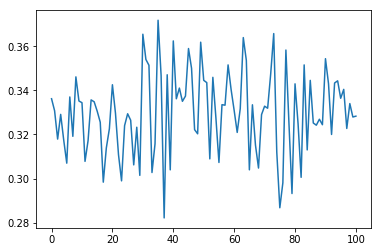

Epoch  4 Summary:  Training_auc : 0.7575361867142741  , Validation_auc :  0.7486363390880124  ,Test_auc :  0.753705224507749 Test_auc on short visits: 0.7587815675006325 Test_auc on long visits: 0.7609630226356306  Avg Loss:  0.3297672051649792 Train Time (3m 25s) Eval Time (3m 24s)


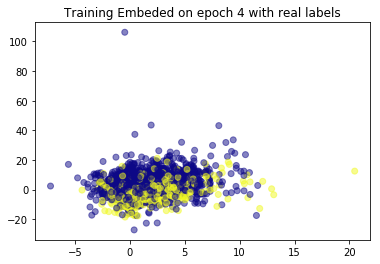

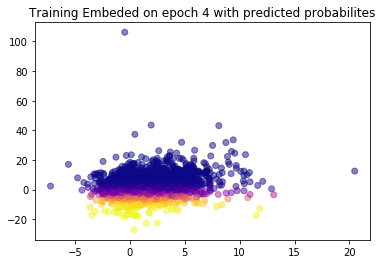


 Current running on: Epoch  5 Training loss:  Average loss 0.32999490005060206


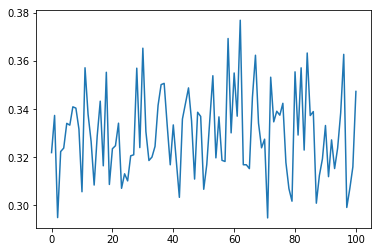

Epoch  5 Summary:  Training_auc : 0.7647532461101079  , Validation_auc :  0.7538406147309997  ,Test_auc :  0.7596265133425206 Test_auc on short visits: 0.7515954485477858 Test_auc on long visits: 0.7724844890322482  Avg Loss:  0.32999490005060206 Train Time (3m 19s) Eval Time (2m 50s)


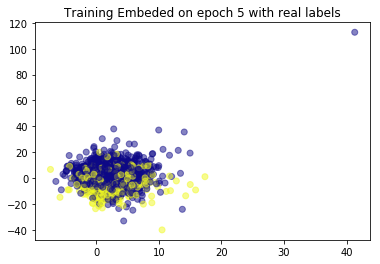

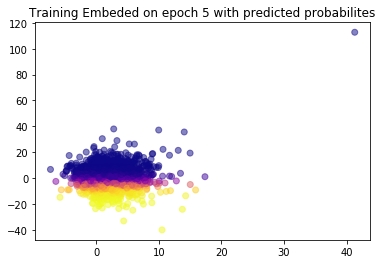


 Current running on: Epoch  6 Training loss:  Average loss 0.32921396800697345


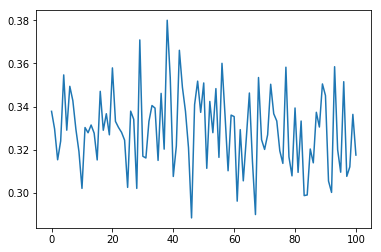

Epoch  6 Summary:  Training_auc : 0.7707355206541191  , Validation_auc :  0.7620004468219558  ,Test_auc :  0.764639260910461 Test_auc on short visits: 0.7577409605365608 Test_auc on long visits: 0.7763800331147067  Avg Loss:  0.32921396800697345 Train Time (4m 7s) Eval Time (2m 33s)


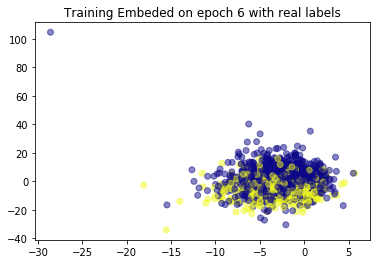

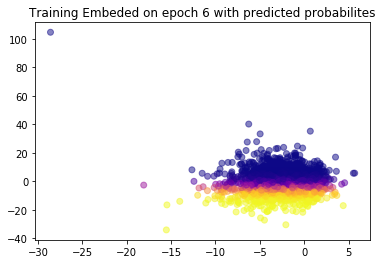


 Current running on: Epoch  7 Training loss:  Average loss 0.32963375638116543


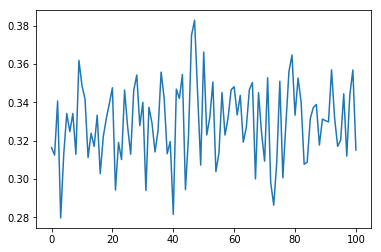

Epoch  7 Summary:  Training_auc : 0.7700394525223622  , Validation_auc :  0.7597007216082268  ,Test_auc :  0.7610629787733533 Test_auc on short visits: 0.7571109000989845 Test_auc on long visits: 0.7713796960970088  Avg Loss:  0.32963375638116543 Train Time (3m 9s) Eval Time (2m 5s)


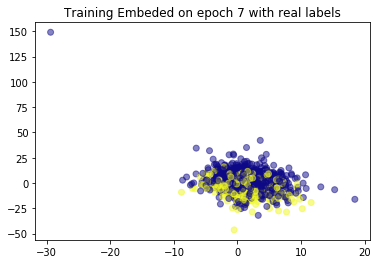

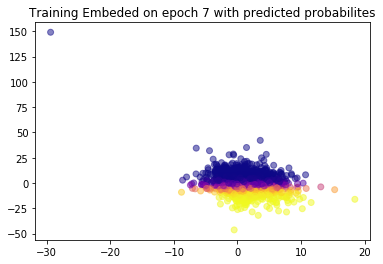


 Current running on: Epoch  8 Training loss:  Average loss 0.3297350900435989


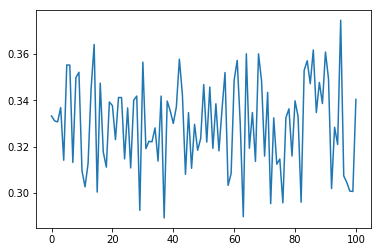

Epoch  8 Summary:  Training_auc : 0.7656769843664557  , Validation_auc :  0.7532105173025802  ,Test_auc :  0.7613328827049644 Test_auc on short visits: 0.7558820075433275 Test_auc on long visits: 0.7734951072640359  Avg Loss:  0.3297350900435989 Train Time (2m 54s) Eval Time (2m 9s)


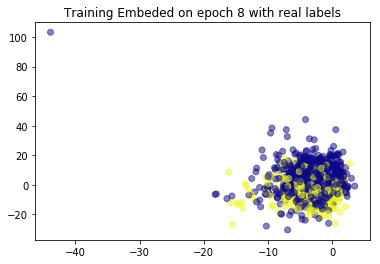

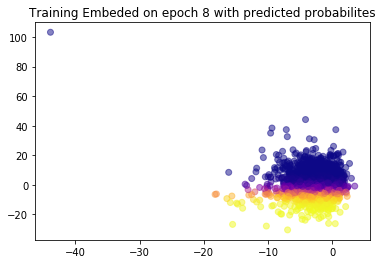


 Current running on: Epoch  9 Training loss:  Average loss 0.32985731688972


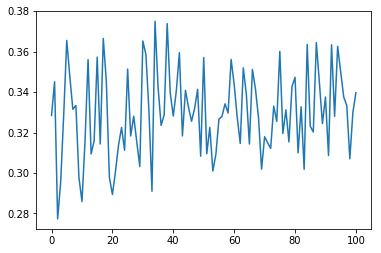

Epoch  9 Summary:  Training_auc : 0.7690478873181308  , Validation_auc :  0.759554258171695  ,Test_auc :  0.764661983898282 Test_auc on short visits: 0.7578442982315575 Test_auc on long visits: 0.7774801241094851  Avg Loss:  0.32985731688972 Train Time (3m 3s) Eval Time (3m 27s)


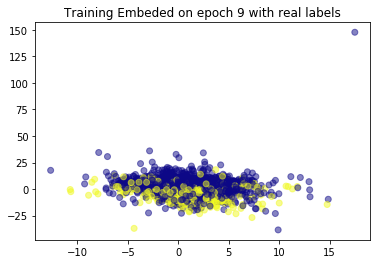

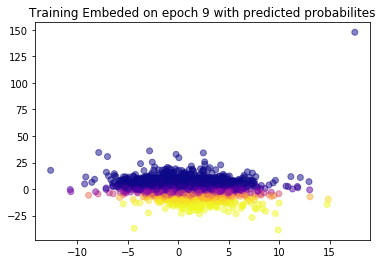


 Current running on: Epoch  10 Training loss:  Average loss 0.32934461183770064


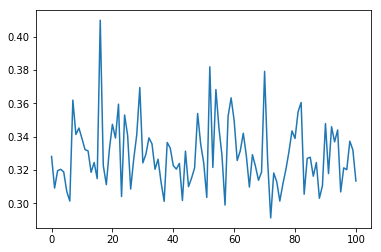

Epoch  10 Summary:  Training_auc : 0.769988343271806  , Validation_auc :  0.7574961999362079  ,Test_auc :  0.7643462952632603 Test_auc on short visits: 0.7523217311255809 Test_auc on long visits: 0.7805784854424661  Avg Loss:  0.32934461183770064 Train Time (2m 52s) Eval Time (2m 6s)


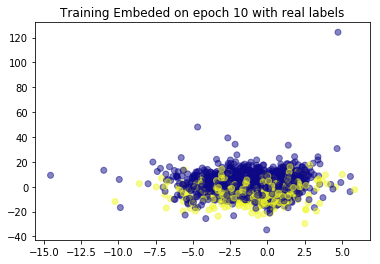

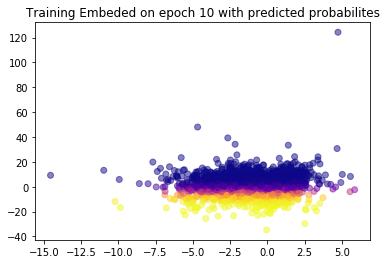


 Current running on: Epoch  11 Training loss:  Average loss 0.3303666871262259


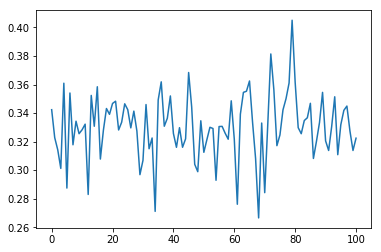

Epoch  11 Summary:  Training_auc : 0.7682311437164678  , Validation_auc :  0.7603189791780046  ,Test_auc :  0.7637824377284563 Test_auc on short visits: 0.7615097246169656 Test_auc on long visits: 0.7727578810501472  Avg Loss:  0.3303666871262259 Train Time (3m 0s) Eval Time (2m 5s)


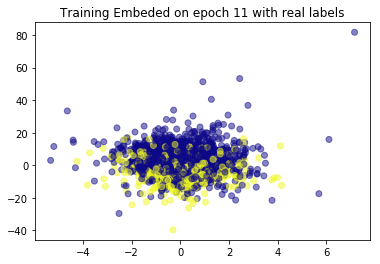

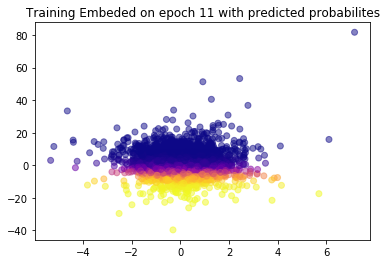


 Current running on: Epoch  12 Training loss:  Average loss 0.32928890131367317


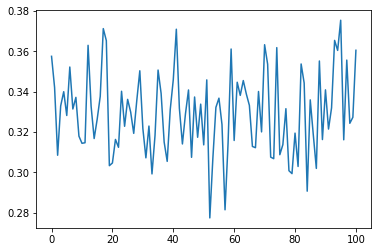

Epoch  12 Summary:  Training_auc : 0.7635669098735098  , Validation_auc :  0.7558108087523558  ,Test_auc :  0.7595653447529453 Test_auc on short visits: 0.7577196138722261 Test_auc on long visits: 0.7691792423189862  Avg Loss:  0.32928890131367317 Train Time (2m 58s) Eval Time (2m 5s)


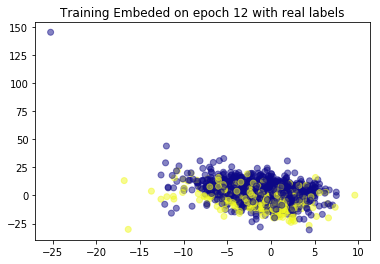

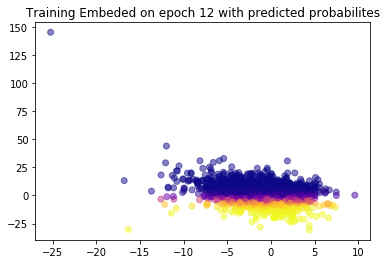


 Current running on: Epoch  13 Training loss:  Average loss 0.3289501681261005


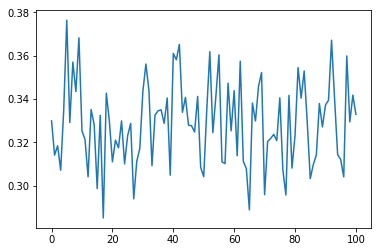

Epoch  13 Summary:  Training_auc : 0.7699968229740886  , Validation_auc :  0.7630271679750518  ,Test_auc :  0.76332844654545 Test_auc on short visits: 0.7608157004926024 Test_auc on long visits: 0.7733951706451062  Avg Loss:  0.3289501681261005 Train Time (4m 0s) Eval Time (1m 45s)


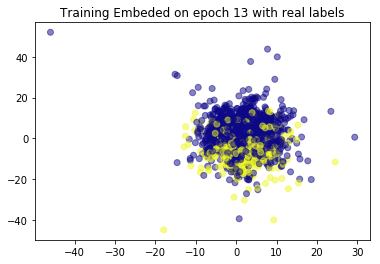

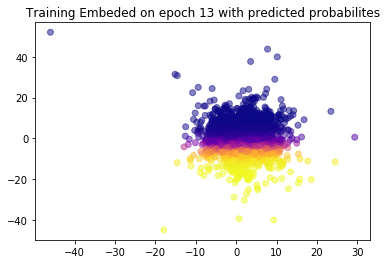


 Current running on: Epoch  14 Training loss:  Average loss 0.32989514176694523


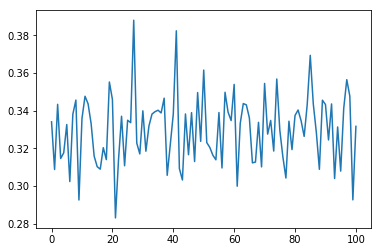

Epoch  14 Summary:  Training_auc : 0.7659928753131308  , Validation_auc :  0.7559083664180065  ,Test_auc :  0.7589040521754576 Test_auc on short visits: 0.7544167374025302 Test_auc on long visits: 0.770680248479887  Avg Loss:  0.32989514176694523 Train Time (3m 11s) Eval Time (2m 11s)


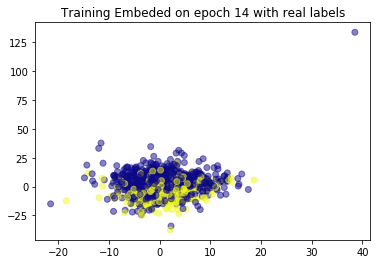

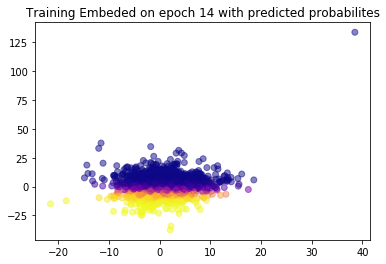


 Current running on: Epoch  15 Training loss:  Average loss 0.32964717195790916


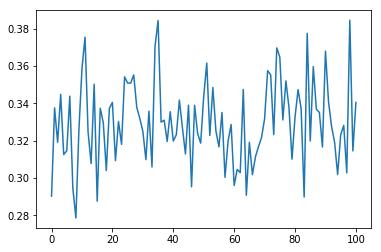

Epoch  15 Summary:  Training_auc : 0.7695777030879836  , Validation_auc :  0.7595231698878929  ,Test_auc :  0.7627536876219547 Test_auc on short visits: 0.7602630717891946 Test_auc on long visits: 0.7726254657095364  Avg Loss:  0.32964717195790916 Train Time (2m 35s) Eval Time (1m 40s)


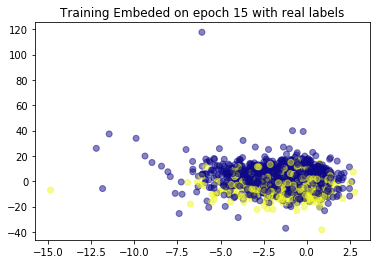

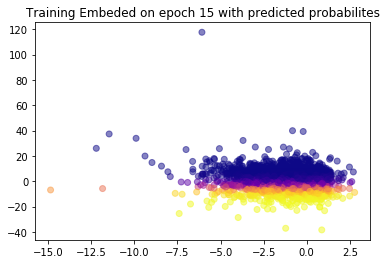


 Current running on: Epoch  16 Training loss:  Average loss 0.32935888774166483


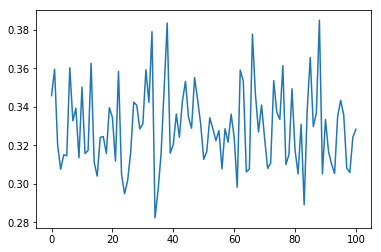

Epoch  16 Summary:  Training_auc : 0.7710037117676839  , Validation_auc :  0.7623675747584369  ,Test_auc :  0.7636043628949563 Test_auc on short visits: 0.7626342684202446 Test_auc on long visits: 0.7715378226264985  Avg Loss:  0.32935888774166483 Train Time (2m 27s) Eval Time (1m 39s)


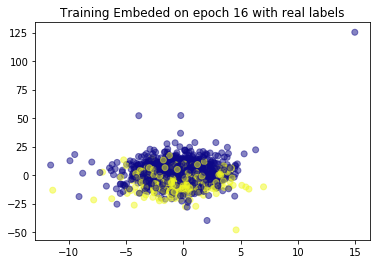

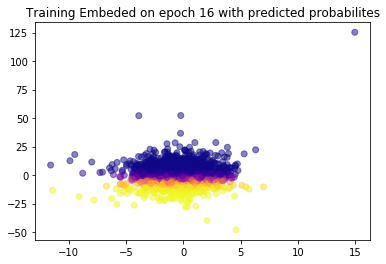


 Current running on: Epoch  17 Training loss:  Average loss 0.3296539170181532


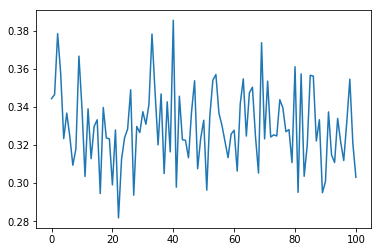

Epoch  17 Summary:  Training_auc : 0.7615707722753711  , Validation_auc :  0.7529551640939784  ,Test_auc :  0.7560128017869651 Test_auc on short visits: 0.76019138209789 Test_auc on long visits: 0.7611505566771359  Avg Loss:  0.3296539170181532 Train Time (2m 28s) Eval Time (3m 8s)


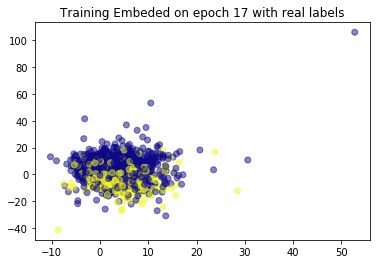

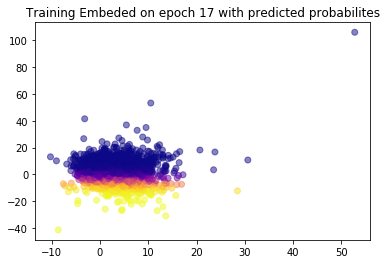


 Current running on: Epoch  18 Training loss:  Average loss 0.33016359675648627


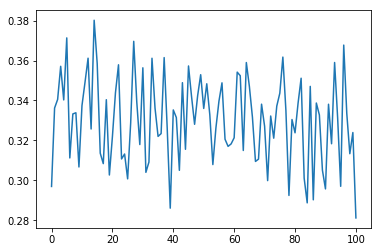

Epoch  18 Summary:  Training_auc : 0.7542367729694726  , Validation_auc :  0.7445410866174516  ,Test_auc :  0.7523614237035234 Test_auc on short visits: 0.7583768583997731 Test_auc on long visits: 0.7613797287116248  Avg Loss:  0.33016359675648627 Train Time (2m 48s) Eval Time (2m 0s)


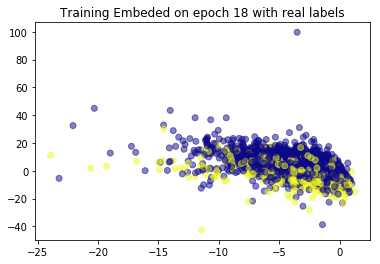

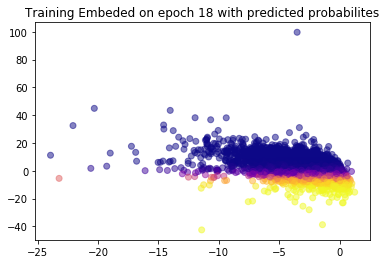


 Current running on: Epoch  19 Training loss:  Average loss 0.33002051165019936


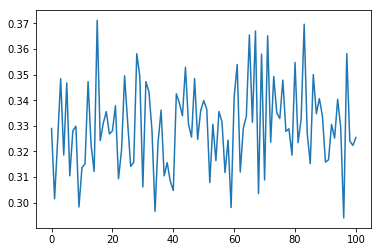

Epoch  19 Summary:  Training_auc : 0.7625453841061199  , Validation_auc :  0.7538126191198254  ,Test_auc :  0.7556827115763082 Test_auc on short visits: 0.7596439040641606 Test_auc on long visits: 0.761613575507728  Avg Loss:  0.33002051165019936 Train Time (4m 18s) Eval Time (2m 5s)


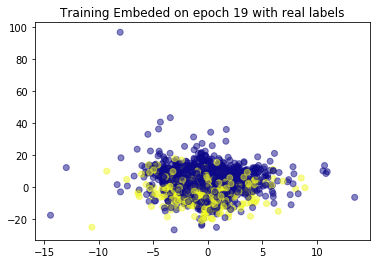

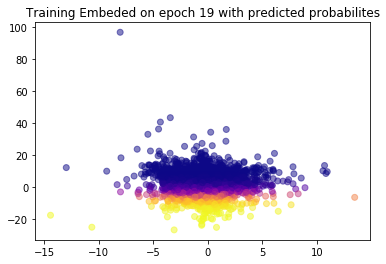

In [11]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
  
    color1 = np.array([item for item in y_real])
    plt.figure()
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

In [12]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

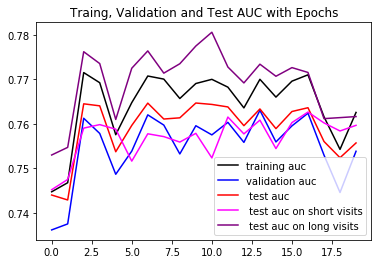

In [13]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [16]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_largeData_dim2')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

Plotly is not rendered on github.The interactive plot is available at **<https://plot.ly/~GinnyJZ/20/training-auc-validation-auc-test-auc-test-auc-on-5-visits/>**

Or you can see a static plot here:

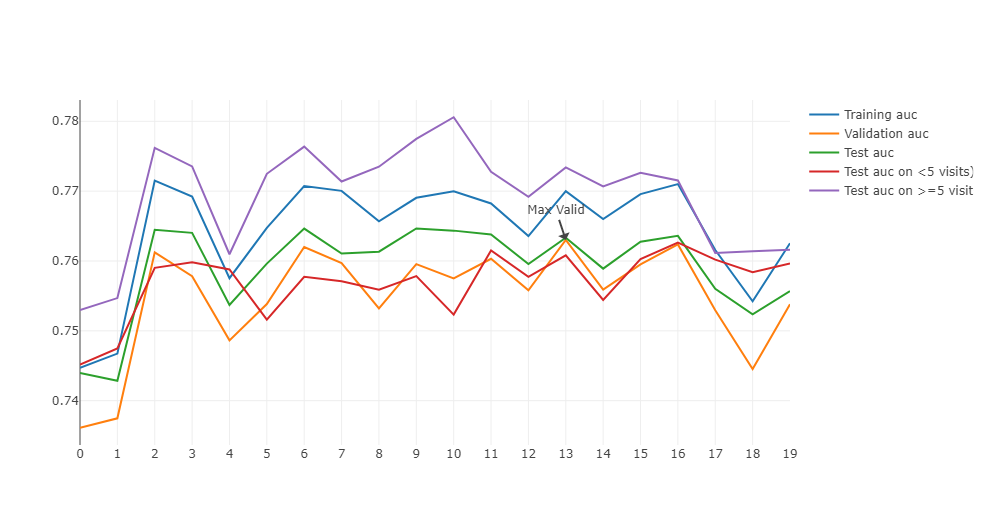

In [1]:
from IPython.display import Image
Image('img/LR_Auc_largeData_dim2.png')

In [15]:
#this block is to explore the embedding matrix vs. types. labels
emb_types = pickle.load(open('Data/h143.types', 'rb'),encoding='bytes')
print(type(emb_types)) #dictionary 
print(len(emb_types)) # it is 20000

<class 'dict'>
15815
